<a href="https://colab.research.google.com/github/arnoldjames98/arnoldjames98.github.io/blob/main/designManufacturing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Biodegradable Seed Spreading Robot](https://arnoldjames98.github.io/)
# Design and Manufacturing Workflow

Imports from https://egr557.github.io/modules/manufacturing/generated/full-workflow/full-workflow.html

In [ ]:
!pip install foldable_robotics
!pip install idealab_tools
!pip install PyQt5
!pip install pyqtgraph
!pip install -U PyYAML

     |████████████████████████████████| 2.2MB 14.2MB/s 
     |████████████████████████████████| 8.3MB 7.3MB/s 
     |████████████████████████████████| 59.9MB 113kB/s 
     |████████████████████████████████| 286kB 25.0MB/s 
     |████████████████████████████████| 829kB 9.1MB/s 
     |████████████████████████████████| 645kB 8.8MB/s 
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
%matplotlib inline
import foldable_robotics
import foldable_robotics.dxf 
import numpy
import shapely.geometry as sg
from foldable_robotics.layer import Layer
from foldable_robotics.laminate import Laminate
import foldable_robotics.manufacturing
import foldable_robotics.parts.castellated_hinge1
import idealab_tools.plot_tris
from math import pi, sin,cos,tan
import idealab_tools.text_to_polygons
foldable_robotics.display_height=200
foldable_robotics.line_width=.5

from foldable_robotics.layer import Layer
from foldable_robotics.laminate import Laminate
import foldable_robotics
import foldable_robotics.dxf 
import foldable_robotics.manufacturing
import foldable_robotics.parts.castellated_hinge1
foldable_robotics.display_height=200
foldable_robotics.line_width=.5
#import workflow_support as ws

import os
import foldable_robotics.solidworks_support

Functions from https://egr557.github.io/modules/manufacturing/generated/full-workflow/full-workflow.html

In [ ]:
def get_bodies(filename, layername, num_layers):
    body = foldable_robotics.dxf.read_lwpolylines(filename,layer=layername, arc_approx = 10)

    bodies = [Layer(sg.Polygon(item)) for item in body]
    body = bodies.pop(0)
    for item in bodies:
        body ^= item
    body = body.to_laminate(num_layers)
    return body
def get_hinge_lines(filename,layername):
    hinge_lines1 = foldable_robotics.dxf.read_lines(filename,layer=layername)
    hinge_lines2 = foldable_robotics.dxf.read_lwpolylines(filename,layer=layername)
    hinge_lines3 = []
    for points in hinge_lines2:
        hinge_lines3.append(points[:2])
    hinge_lines = hinge_lines1 +hinge_lines3
    return hinge_lines
def hinge_lines_to_hinges(hinge_lines,hinge):
    lam = Layer().to_laminate(len(hinge))
    all_hinges = []    
    for p3,p4 in hinge_lines:
        all_hinges.append(hinge.map_line_stretch((0,0),(1,0),p3,p4))
    all_hinges = lam.unary_union(*all_hinges)
    return all_hinges
        
def get_cuts(filename,layername,thickness,num_layers):
    cut_lines = foldable_robotics.dxf.read_lines(filename,layer=layername)
    cut_lines += foldable_robotics.dxf.read_lwpolylines(filename,layer=layername, arc_approx = 10)
    
    cuts = []
    for item in cut_lines:
        cuts.append(Layer(sg.LineString(item)))
    cuts = Layer().unary_union(*cuts)
    cuts<<=thickness/2
    cuts = cuts.to_laminate(num_layers)
    return cuts    
def get_holes(filename, layername,num_layers):
    holes = foldable_robotics.dxf.read_circles(filename,layer='holes')
    
    holes2 = []
    for center, radius in holes:
        holes2.append(sg.Point(*center).buffer(radius))
    holes_layer = Layer(*holes2)
    holes_lam = holes_layer.to_laminate(num_layers)  
    return holes_lam
def hinge_width_calculator(desired_degrees,thickness):
    theta = (180-desired_degrees)*pi/180
    w=thickness/tan(theta)
    return w
def polys_to_layer(l1):
    l1 = [sg.Polygon(item) for item in l1]
    l11 = Layer(l1.pop(0))
    for item in l1:
        l11 ^= Layer(item)
    return l11
    
def output_pdf(filename,design2,x,y,layers_separate = True):
    design2 = design2.translate(x,y)
    design2=design2.scale(1/25.4,1/25.4)
    design2=design2.scale(foldable_robotics.pdf.ppi,foldable_robotics.pdf.ppi)
    if isinstance(design2,Laminate):
        if not layers_separate:
            p=foldable_robotics.pdf.Page(filename+'.pdf')
            for d in design2:
    #        d = design2[0]
                for item in d.exteriors()+d.interiors():
                    p.draw_poly(item)
            p.close()
        else:
            for ii,d in enumerate(design2):
                p=foldable_robotics.pdf.Page(filename+'{0:03f}.pdf'.format(ii))
                for item in d.exteriors()+d.interiors():
                    p.draw_poly(item)
                p.close()

    elif isinstance(design2,Layer):
        p=foldable_robotics.pdf.Page(filename+'.pdf')
        for item in design2.exteriors()+design2.interiors():
            p.draw_poly(item)
        p.close()
        
def build_layer_numbers(num_layers, text_size = None, prop=None):
    text_size = text_size or 1
    prop = prop or {'family':'Arial','size':text_size}
    layer_ids = []
    for ii in range(num_layers): 
    
        l = idealab_tools.text_to_polygons.text_to_polygons('Layer '+str(ii),prop=prop)
        layer_ids.append(l)
    
    layer_ids = [polys_to_layer(item) for item in layer_ids]
    layer_id = Laminate(*layer_ids)
    return layer_id
def build_web(design2,keepout,support_width,jig_diameter,jig_hole_spacing,is_adhesive):
    num_layers = len(design2)

    layer_id = build_layer_numbers(num_layers,text_size=jig_diameter)

    design_outer = foldable_robotics.manufacturing.unary_union(design2)
    bb1= (design_outer<<jig_hole_spacing/2).bounding_box()
    (x1,y1),p2 = bb1.bounding_box_coords()
    w,h = bb1.get_dimensions()
    w2 = round(w/jig_hole_spacing)*jig_hole_spacing
    h2 = round(h/jig_hole_spacing)*jig_hole_spacing
    
    points = []
    points.append(sg.Point(x1,y1))
    points.append(sg.Point(x1+w2,y1))
    points.append(sg.Point(x1,y1+h2))
    points.append(sg.Point(x1+w2,y1+h2))
    
    layer_id = layer_id.translate(x1+jig_diameter,y1-jig_diameter/2)
    placement_holes2 = Layer(*points)
    placement_holes2<<=(jig_diameter/2)
    sheet = (placement_holes2<<10).bounding_box()
    placement_holes2=placement_holes2.to_laminate(num_layers)
    sheet=sheet.to_laminate(num_layers)
    
    removable_scrap = calculate_removable_scrap(design2,sheet,support_width,is_adhesive)
    
    web = (removable_scrap-placement_holes2)-layer_id
    return web,sheet
    
def calculate_removable_scrap(design,sheet,width,is_adhesive):
    '''this computes all removable scrap given a sheet, a design, and a clearance width'''
    all_scrap = sheet-design

    ru = foldable_robotics.manufacturing.not_removable_up(design,is_adhesive)
    rd = foldable_robotics.manufacturing.not_removable_down(design,is_adhesive)
    
    removable_scrap_up = all_scrap-(ru<<width)
    removable_scrap_down = all_scrap-(rd<<width)

    removable_scrap = removable_scrap_up|removable_scrap_down
    return removable_scrap

Import the .yaml file

In [ ]:
#user_path = os.path.abspath(os.path.expanduser(‘~’)) user_path

#folder = '../../../_cad/spherical_example/'
input_filename = '/content/singleLegDrawing - Sheet1_Drawing View1.yml'
output_file_name = 'design.dxf'

In [ ]:
round_digits = 3
prescale=1000
jig_diameter = 5
support_width = 1
kerf = .05
jig_hole_spacing=20
is_adhesive = [False,True,False,True,False]
arc_approx = 10
foldable_robotics.solidworks_support.process(input_filename,output_file_name,prescale,round_digits)

(<foldable_robotics.layer.Layer at 0x7f3d45481a10>,
  <foldable_robotics.solidworks_support.Component at 0x7f3d44fd5bd0>])

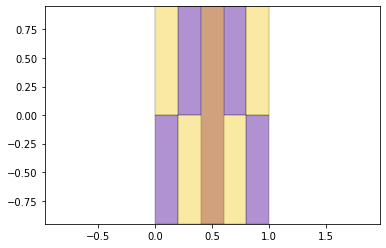

In [ ]:
hinge = foldable_robotics.parts.castellated_hinge1.generate()
w=hinge_width_calculator(150,1.1)
hinge = hinge.scale(1,w)
hinge.plot()

In [ ]:
output_file_name

'design.dxf'

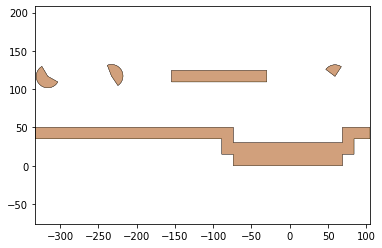

In [ ]:
NUMLAYERS = len(hinge)
body = get_bodies(output_file_name,'body',NUMLAYERS)
body = foldable_robotics.manufacturing.cleanup(body,.01)
body.plot()

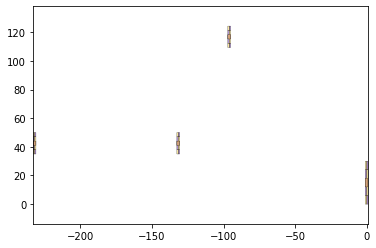

In [ ]:
joint_lines= get_hinge_lines(output_file_name,'joints')
joints = hinge_lines_to_hinges(joint_lines,hinge)
joints = foldable_robotics.manufacturing.cleanup(joints,.02)
joints.plot()

In [ ]:
cuts = get_cuts(output_file_name,'cuts',.02,NUMLAYERS)
#cuts.plot()
holes = get_holes(output_file_name,'holes',NUMLAYERS)
#holes.plot()
hole,dummy = foldable_robotics.manufacturing.calc_hole(joint_lines,w)
hole = hole.to_laminate(NUMLAYERS)
hole<<=.2
hole.plot()

('zero-size array to reduction operation minimum which has no identity',)


<Figure size 432x288 with 0 Axes>

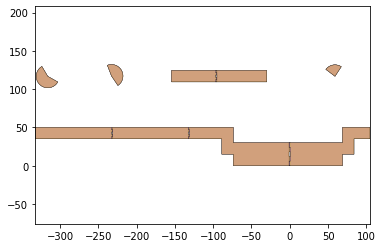

In [ ]:
design2 = body- hole - joints - cuts - holes
design2.plot()

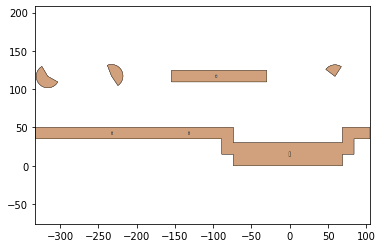

In [ ]:
keepout =  foldable_robotics.manufacturing.keepout_laser(design2)
keepout.plot()

In [ ]:
web,sheet=build_web(design2,keepout,support_width,jig_diameter,jig_hole_spacing,is_adhesive)
web.plot()

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


KeyboardInterrupt: ignored

In [ ]:
sheet.plot()

In [ ]:
second_pass_scrap = sheet-keepout
first_pass_scrap = sheet - design2-second_pass_scrap
first_pass_scrap = foldable_robotics.manufacturing.cleanup(first_pass_scrap,.00001)
first_pass_scrap.plot()

In [ ]:
support = foldable_robotics.manufacturing.support(design2,foldable_robotics.manufacturing.keepout_laser,support_width,support_width/2)
support.plot()

In [ ]:
#Calculate the web by using only the material which can be cut, minus a gap determined by the support width.  Is that the only material you can use?
supported_design = web|design2|support
supported_design.plot()

In [ ]:
#cut_line = keepout<<kerf
cut_material = (keepout<<kerf)-keepout
cut_material.plot()

In [ ]:
final_cut = sheet - keepout
final_cut = final_cut[0]
final_cut.plot()

In [ ]:
remaining_material = supported_design-cut_material
remaining_material.plot()

In [ ]:
remaining_parts = foldable_robotics.manufacturing.find_connected(remaining_material,is_adhesive)
for item in remaining_parts:
    item.plot(new=True)